In [1]:
!python -V

Python 3.9.12


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

In [3]:
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [64]:
print(f"Pandas version: {pd.__version__}")
print(f"Scikit learn version: {sklearn.__version__}")
print(f"Seaborn learn version: {sns.__version__}")

Pandas version: 1.4.2
Scikit learn version: 1.0.2
Seaborn learn version: 0.11.2


# Data ingestion

In [5]:
def read_df(filepath: str, verbose: bool=False):
    df = pd.read_parquet(filepath)
    if verbose: 
        print(f"The dataframe has {len(df.columns)} columns with types \n{df.dtypes}")
    
    # Add a new feature idndicating the trip duration in minutes
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)
    if verbose:
        print(f"The average of the trip duration is {df['duration'].mean():.3f} minutes and its standard deviation {df['duration'].std():.3f}")
    
    # Remove toe short or too long trips from the dataframe
    nr_before_outlier_removing = len(df)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    if verbose:
        print(f"The portion of remaining datapoints is {100*len(df)/nr_before_outlier_removing}")
    
    return df

In [6]:
df_train = read_df('./data/yellow_tripdata_2023-01.parquet', verbose=True)

The dataframe has 19 columns with types 
VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object
The average of the trip duration is 15.669 minutes and its standard deviation 42.594
The portion of remaining datapoints is 98.1220282212598


In [7]:
df_val = read_df('./data/yellow_tripdata_2023-02.parquet')

In [27]:
len(df_train), len(df_val)

(3009173, 2855951)

# Feature extraction

In [50]:
def location_encoding_vectorizer(df):
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    dv = DictVectorizer()
    dv = dv.fit(df[categorical].to_dict(orient='records'))
    return dv

In [51]:
dv = location_encoding_vectorizer(df_train)

In [52]:
def feature_matrix(df, vectorizer):
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return vectorizer.transform(df[categorical].to_dict(orient='records'))

In [53]:
X_train = feature_matrix(df_train, dv)

In [54]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [55]:
X_val = feature_matrix(df_val, dv)

In [56]:
X_val

<2855951x515 sparse matrix of type '<class 'numpy.float64'>'
	with 5711894 stored elements in Compressed Sparse Row format>

In [57]:
def target_variable(df, target: str='duration'):
    return df[target].values

In [58]:
y_train = target_variable(df_train)
y_val = target_variable(df_val)

# Model training

In [59]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [60]:
y_train_pred = lr.predict(X_train)
mean_squared_error(y_train, y_train_pred, squared=False)

7.649261027792376

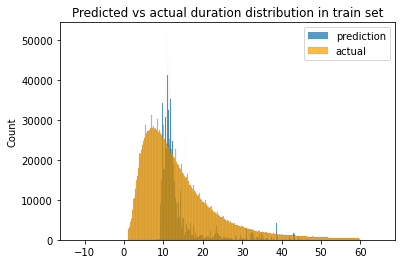

In [65]:
sns.histplot(y_train_pred, label='prediction')
sns.histplot(y_train, label='actual', color="orange")

plt.title("Predicted vs actual duration distribution in train set")
plt.legend();

# Model evaluation

In [61]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.811832836304415

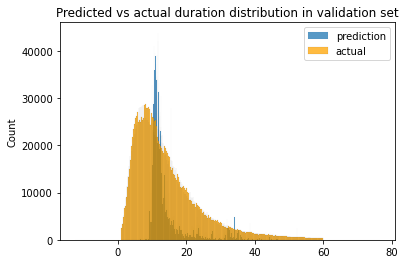

In [66]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_val, label='actual', color="orange")

plt.title("Predicted vs actual duration distribution in validation set")
plt.legend();

# Saving the model

In [68]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)